## Using Fundamental Data to Predict Stock Price

**Adam Magyar and Scott Elmore** <br>
 **DSC 478**


### Introduction:

The dataset used here was created by Scott Elmore using yfinance to import data from Yahoo Fianance. The objective of the data gathering was to bring in as many features as possible from Yahoo so that machine learning could be applied. As described within the document, several more features were further created by combining the features from Yahoo. The application of the machine learning on the dataset was intended to give insights into pricing and return behavior of stocks. 

Preprocessing and data exploration was performed and shown where appropriate in the selected jupyter notebooks. Upon completion of the data exploration, machine learning concepts including regression, classification and feature selection were performed in python to gain insights. Some models performed well while others had little explanatory power. All models are presented within the documents to show work that was done.


The first part of this notebook attempts to predict stock price based on fundamental balance sheet and income statement data for different companies. 

The data contained many technical indicators and other data fields that were not specifically fundamental data. The first steps remove those features. Additionally, all data was reported in total dollar terms. In order to be able to properly compare stock prices, all features were then converted into a per share amount.

A decision that was made on the data was to fill in blanks with zeroes. Given that data can be very different for each company, it did not make sense to fill gaps with mean or other measures. Additionally, removing all instances that had blanks would have significantly reduced the size of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn import preprocessing
from sklearn import neighbors, tree, naive_bayes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

The fist step is to read in the dataset. The dataset was provided with other materials so please change directory to where it was saved on your drive.

In [2]:
data = pd.read_csv("stock_complete_info.csv", sep=',').fillna(0)

In [3]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,Repurchase Of Stock,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,country,industry,longBusinessSummary,sector,sharesOutstanding,sharesShort,Return,aoi,kama,roc,rsi,tsi,adi,cmf,emi,atr,bband_h,bband_l,adx_pos,adx_neg,macd,Short Term Investments,Deferred Long Term Liab,Qtr,Entire Market Return,Outlier Removed Market Return,Beat Entire Market Return,Beat Outlier Removed Market Return
0,A 2019_Q2,2019-04-30,76.75,77.89,76.69,77.80,1726200.0,0.0,0.0,1.059000e+09,5.293000e+09,4.653000e+09,4.848000e+09,415000000.0,9.501000e+09,3000000.0,204000000.0,73000000.0,8.330000e+08,3.589000e+09,-5.210000e+08,5.980000e+08,1.226000e+09,1.892000e+09,-5.210000e+08,1.035000e+09,3.102000e+09,1.180000e+08,2.000000e+08,966000000.0,1.787000e+09,7.060000e+08,3.290000e+08,0.0,0.0,-1000000.0,-15000000.0,-3.500000e+07,56000000.0,-61000000.0,-275000000.0,32000000.0,197000000.0,-156000000.0,-93000000.0,-1000000.0,-59000000.0,79000000.0,-56000000.0,-32000000.0,-40000000.0,27000000.0,-34000000.0,0.0,0.0,104000000.0,0.0,219000000.0,0.000000e+00,389000000.0,723000000.0,230000000.0,230000000.0,0.0,-20000000.0,0.0,0.0,0.0,22000000.0,1.357000e+09,1.127000e+09,6.340000e+08,-11000000.0,0.0,197000000.0,197000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,-6.917019,-2.619706,76.215598,-3.173615,50.321067,-12.902244,1.451059e+07,-0.135524,7.299270,1.521994,0.0,0.0,14.867414,29.279115,-0.610567,0.0,0.0,2019_Q2,2.110926,1.502301,0,0
1,A 2019_Q3,2019-07-31,69.71,70.18,68.45,68.94,3846100.0,0.0,0.0,1.107000e+09,5.277000e+09,4.704000e+09,4.748000e+09,666000000.0,9.452000e+09,3000000.0,130000000.0,-18000000.0,8.330000e+08,3.593000e+09,-5.140000e+08,6.110000e+08,1.382000e+09,2.080000e+09,-5.140000e+08,8.500000e+08,3.189000e+09,1.020000e+08,4.800000e+07,998000000.0,1.786000e+09,6.790000e+08,3.540000e+08,410000000.0,0.0,-2000000.0,29000000.0,-1.193000e+09,600000000.0,497000000.0,23000000.0,2000000.0,194000000.0,-383000000.0,-50000000.0,-1000000.0,314000000.0,76000000.0,-51000000.0,-5000000.0,-48000000.0,45000000.0,-30000000.0,-1000000.0,-4000000.0,102000000.0,0.0,231000000.0,0.000000e+00,322000000.0,737000000.0,313000000.0,313000000.0,0.0,-21000000.0,0.0,0.0,0.0,37000000.0,1.367000e+09,1.054000e+09,6.300000e+08,-82000000.0,0.0,194000000.0,194000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,3.067090,-2.039000,69.517929,-1.612673,41.318386,-14.191339,2.075694e+07,-0.038812,29.012506,1.366337,0.0,0.0,17.365258,27.167584,-0.590718,0.0,0.0,2019_Q3,-2.051225,-2.049707,1

The dataset shown above shows several features not needed for this analysis. The next couple of steps remove these features. 

In [4]:
dataFundamentals = data.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'Dividends', 
                            'Stock Splits', 'Issuance Of Stock', 'Repurchase Of Stock', 'longBusinessSummary', 
                             'country', 'industry'], axis=1)

In [5]:
dataFundamentals.drop(dataFundamentals.iloc[:, 70:86], axis=1, inplace=True)

In [6]:
dataFundamentals.drop(dataFundamentals.iloc[:, 72:], axis=1, inplace=True)

In [7]:
dataFundamentals.head()

,Unnamed: 0,Close,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,sector,sharesOutstanding,sharesShort,Deferred Long Term Liab,Qtr
0,A 2019_Q2,77.80,1.059000e+09,5.293000e+09,4.653000e+09,4.848000e+09,415000000.0,9.501000e+09,3000000.0,204000000.0,73000000.0,8.330000e+08,3.589000e+09,-5.210000e+08,5.980000e+08,1.226000e+09,1.892000e+09,-5.210000e+08,1.035000e+09,3.102000e+09,1.180000e+08,2.000000e+08,966000000.0,1.787000e+09,7.060000e+08,3.290000e+08,0.0,0.0,-1000000.0,-15000000.0,-3.500000e+07,56000000.0,-61000000.0,-275000000.0,197000000.0,-156000000.0,-1000000.0,-59000000.0,79000000.0,-56000000.0,-32000000.0,-40000000.0,27000000.0,-34000000.0,0.0,0.0,104000000.0,0.0,219000000.0,0.000000e+00,389000000.0,723000000.0,230000000.0,230000000.0,0.0,-20000000.0,0.0,0.0,0.0,22000000.0,1.357000e+09,1.127000e+09,6.340000e+08,-11000000.0,0.0,197000000.0,197000000.0,Healthcare,309651008,5258241.0,0.0,2019_Q2
1,A 2019_Q3,68.94,1.107000e+09,5.277000e+09,4.704000e+09,4.748000e+09,666000000.0,9.452000e+09,3000000.0,130000000.0,-18000000.0,8.330000e+08,3.593000e+09,-5.140000e+08,6.110000e+08,1.382000e+09,2.080000e+09,-5.140000e+08,8.500000e+08,3.189000e+09,1.020000e+08,4.800000e+07,998000000.0,1.786000e+09,6.790000e+08,3.540000e+08,410000000.0,0.0,-2000000.0,29000000.0,-1.193000e+09,600000000.0,497000000.0,23000000.0,194000000.0,-383000000.0,-1000000.0,314000000.0,76000000.0,-51000000.0,-5000000.0,-48000000.0,45000000.0,-30000000.0,-1000000.0,-4000000.0,102000000.0,0.0,231000000.0,0.000000e+00,322000000.0,737000000.0,313000000.0,313000000.0,0.0,-21000000.0,0.0,0.0,0.0,37000000.0,1.367000e+09,1.054000e+09,6.300000e+08,-82000000.0,0.0,194000000.0,194000000.0,Healthcare,309651008,5258241.0,0.0,2019_Q3
2,A 2019_Q4,75.40,5.110000e+08,5.270000e+09,3.878000e+09,4.747000e+09,381000000.0,8.625000e+09,3000000.0,176000000.0,-122000000.0,9.620000e+08,3.107000e+09,-4.040000e+08,6.120000e+08,1.765000e+09,1.622000e+09,-4.040000e+08,8.390000e+08,3.457000e+09,9.900000e+07,1.129000e+09,856000000.0,1.294000e+09,6.600000e+08,3.160000e+08,0.0,504000000.0,-3000000.0,8000000.0,-5.100000e+07,600000000.0,-582000000.0,10000000.0,191000000.0,-390000000.0,1000000.0,242000000.0,55000000.0,-51000000.0,-10000000.0,-41000000.0,29000000.0,-47000000.0,-1000000.0,-4000000.0,101000000.0,0.0,222000000.0,0.000000e+00,341000000.0,692000000.0,250000000.0,250000000.0,0.0,-18000000.0,0.0,0.0,0.0,31000000.0,1.274000e+09,1.024000e+09,5.820000e+08,-28000000.0,0.0,191000000.0,191000000.0,Healthcare,309651008,5258241.0,0.0,2019_Q4
3,A 2020_Q1,82.35,5.380000e+08,5.343000e+09,3.897000e+09,5.125000e+09,381000000.0,9.022000e+09,3000000.0,181000000.0,178000000.0,9.810000e+08,3.112000e+09,-3.990000e+08,6.370000e+08,2.15

The research was able to look at four quarters of data. Unfortunately, the most recent quarter which ended March 2020 so significant stock market volatility where many stocks sold off and prices no longer reflected previous fundamental company results. Therefore, the dataset was reduced further to exclude the first quarter of 2020.

In [8]:
fundamentalsPerShareExQ1202 = dataFundamentals[~dataFundamentals.Qtr.str.contains("2020_Q1")]

Total values were divided by the number of shares outstanding to give values per share. 

In [9]:
fundamentalsPerShare = fundamentalsPerShareExQ1202.iloc[:,2:67].div(fundamentalsPerShareExQ1202.sharesOutstanding, axis=0)

In [10]:
fundamentalsPerShare['sharesShort'] = fundamentalsPerShareExQ1202.iloc[:,69].div(fundamentalsPerShareExQ1202.sharesOutstanding, axis=0)

In [11]:
fundamentalsPerShare['Close'] = data['Close']

In [12]:
fundamentalsPerShare = fundamentalsPerShare.fillna(0)
fundamentalsPerShare.head()

,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Net Income,Change In Cash,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,sharesShort,Close
0,3.419979,17.093437,15.026594,15.656335,1.340218,30.682929,0.009688,0.658806,0.235749,2.690125,11.590468,-1.682539,1.931206,3.959296,6.110104,-1.682539,3.342473,10.017729,0.381074,0.645888,3.119641,5.771013,2.279986,1.062486,0.000000,0.000000,-0.003229,-0.048442,-0.113030,0.180849,-0.196996,-0.888097,0.636200,-0.503793,-0.003229,-0.190537,0.255126,-0.180849,-0.103342,-0.129178,0.087195,-0.109801,0.000000,0.000000,0.335862,0.0,0.707248,0.000000,1.256253,2.334887,0.742772,0.742772,0.000000,-0.064589,0.0,0.0,0.0,0.071048,4.382353,3.639581,2.047466,-0.035524,0.0,0.636200,0.636200,0.016981,77.80
1,3.574992,17.041766,15.191296,15.333391,2.150808,30.524687,0.009688,0.419827,-0.058130,2.690125,11.603385,-1.659933,1.973189,4.463089,6.717240,-1.659933,2.745026,10.298691,0.329403,0.155013,3.222983,5.767784,2.192791,1.143223,1.324071,0.000000,-0.006459,0.093654,-3.852724,1.937665,1.605033,0.074277,0.626512,-1.236876,-0.003229,1.014045,0.245438,-0.164702,-0.016147,-0.155013,0.145325,-0.096883,-0.003229,-0.012918,0.329403,0.0,0.746001,0.000000,1.039880,2.380099,1.010815,1.010815,0.000000,-0.067818,0.0,0.0,0.0,0.119489,4.414647,3.403832,2.034549,-0.264814,0.0,0.626512,0.626512,0.016981,68.94
2,1.650245,17.019160,12.523776,15.330162,1.230417,27.853938,0.009688,0.568382,-0.393992,3.106723,10.033877,-1.304695,1.976419,5.699965,5.238155,-1.304695,2.709502,11.164181,0.319715,3.646040,2.764402,4.178898,2.131432,1.020504,0.000000,1.627639,-0.009688,0.025836,-0.164702,1.937665,-1.879535,0.032294,0.616823,-1.259482,0.003229,0.781525,0.177619,-0.164702,-0.032294,-0.132407,0.093654,-0.151784,-0.003229,-0.012918,0.326174,0.0,0.716936,0.000000,1.101240,2.234774,0.807361,0.807361,0.000000,-0.058130,0.0,0.0,0.0,0.100113,4.114309,3.306949,1.879535,-0.090424,0.0,0.616823,0.616823,0.016981,75.40
4,0.000000,51.888186,42.168900,22.993883,2.888354,73.424445,0.010757,0.285070,-2.560255,20.040985,0.000000,-26.344805,11.289862,4.458931,11.956819,-26.344805,38.511393,17.927161,5.696029,22.993883,3.576826,9.687014,8.116437,6.863204,2.285942,0.005379,-0.005379,-0.650821,0.575519,0.000000,-0.236662,-0.715365,0.430295,-0.274313,-0.129088,-0.484082,0.914377,0.000000,0.220526,-0.376508,-0.247420,-0.489460,0.000000,-0.236662,0.037651,0.0,1.177932,8.261662,0.457188,2.000871,0.597034,0.597034,-0.005379,-0.161361,0.0,0.0,0.0,0.430295,12.806652,12.209618,10.805781,0.580898,0.0,0.747637,0.430295,0.062570,23.41
5,0.279692,51.845156,47.036611,22.117158,3.248726,78.695558,0.010757,0.338857,-2.985171,23.036913,0.806803,-26.753585,9.391186,4.727865,13.785573,-26.753585,43.244637,18.986762,5.986478,21.030663,3.549933,9.676256,8.842560,7.981970

Outliers were removed in the event that some stock price changes from quarter to quarter were far greater than ordinary stock moves.

In [13]:
q_low = fundamentalsPerShare['Close'].quantile(0.01)
q_hi  = fundamentalsPerShare['Close'].quantile(0.99)

fundsExOutliers = fundamentalsPerShare[(fundamentalsPerShare['Close'] < q_hi) & 
                                       (fundamentalsPerShare['Close'] > q_low)]

After block 13, the dataset is now ready for analysis. The fist steps create the y and x variables for the regression

In [14]:
xTarget = fundsExOutliers.drop(['Close'], axis=1)
x = np.array(xTarget)
y = np.array(fundsExOutliers['Close'])

In [15]:
x = np.array([np.concatenate((v,[1])) for v in x])

In [16]:
linreg = LinearRegression()

linreg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

After the model is run, some predictions are shown for y to ensure the model was run with correct looking output. Further, errors are calculated based on actual prices for stocks compared to predicted by the regression model. These errors are used to calculate a total error of the model which was 40.38. The error is not insignificant given that the mean stock price in the dataset was near 70.

In [17]:
print (linreg.predict(x[:10]))

[62.72535286 61.71335114 72.51675902 52.89658617 50.32963885 50.30692233
  1.48294765 60.08182814 62.9065488  22.43064464]


In [18]:
p = linreg.predict(x)

err = abs(p-y)

print (err[:10])

[15.07464714  7.22664886  2.88324098 29.48658617 30.25963885 28.79692233
 30.78705235 33.30182814 34.3365488  12.15064464]


In [19]:
# Dot product of error vector with itself gives us the sum of squared errors
total_error = np.dot(err,err)

# Compute RMSE
rmse_train = np.sqrt(total_error/len(p))
print ('The RMSE of the linear regression model is:')
print(round(rmse_train,2))

The RMSE of the linear regression model is:
40.38


The below graph shows the variables and weights applied to each for the linear regression. Important features for the regression are income and expenses which are intuitive. It's also interesting to note that shares shorted and dividends have a negative impact on price which is also intuitive as dividends paid reduce cash for the company and shares shorted show that some are trading against the stock. 

It is also interesting to note that the amount spent on Research and Development has a positive impact on price. The stock price of a company is rewarded if investors see the company is reinvesting in areas that may lead to more growth in the future.

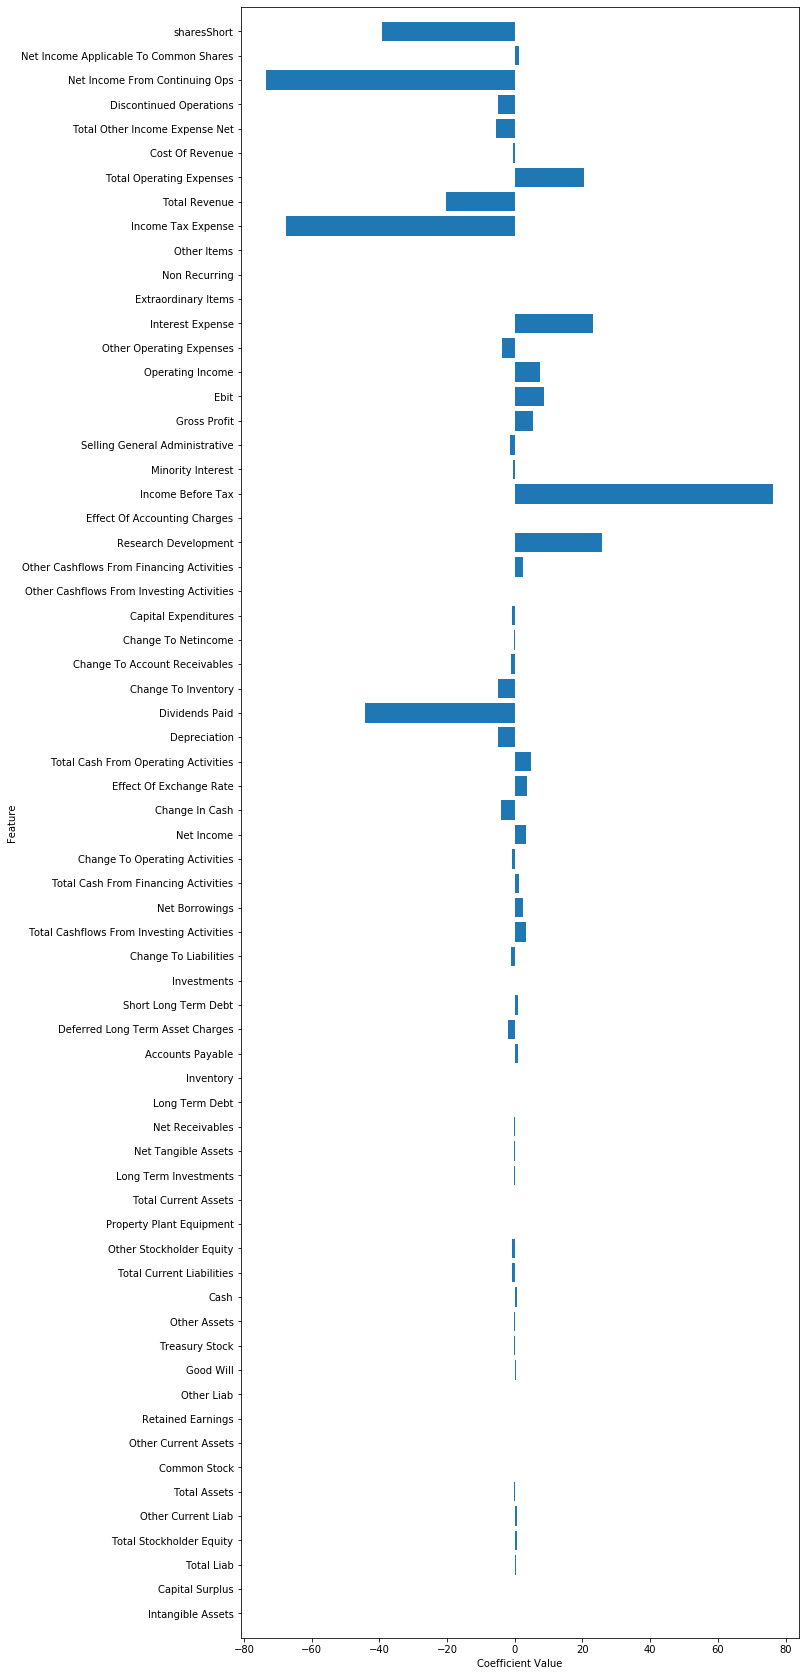

In [20]:
%matplotlib inline
def plot_coefficients(model, n_features, feature_names):
    figure(figsize=(10,30))
    plt.barh(range(n_features), model.coef_[:-1], align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_coefficients(linreg, len(xTarget.columns), xTarget.columns)

The graph below shows the error around predicted and actual values of prices for stocks. There appears to be a positive linear relationship between actual price and predicted price which indicates the model does have some potential benefit. 

There is a lower bound zero on stock prices, but the model was not restrained and several stocks had a negative predicted value, but were priced near 100. Other stocks were predicted around 300, but were priced around 25. In both instances, investors may benefit from further analyzing the cause of these disconnects.

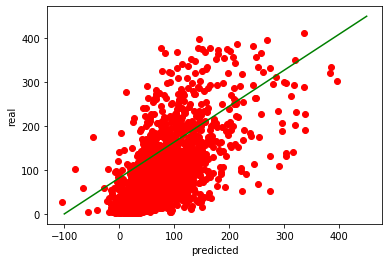

In [21]:
%matplotlib inline
plt.plot(p, y,'ro')
plt.plot([-100,450],[0,450], 'g-')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

The model accuracy is further tested by performing a 10 cross fold validation. Here, data is resampled and tested against the model. The model had a 40 RMSE on the original dataset, but it increased to 44.5 during validation. The increase in error is exagerated and the model appears to still be useful.

In [22]:
n = 10

kf = KFold(n_splits=n)
kf.get_n_splits(x)

xval_err = 0

for train, test in kf.split(x):
    linreg.fit(x[train],y[train])
    p = linreg.predict(x[test])
    e = p-y[test]
    xval_err += np.sqrt(np.dot(e,e)/len(x[test]))
       
rmse_10cv = xval_err/n

In [23]:
method_name = 'Simple Linear Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Simple Linear Regression
RMSE on training: 40.3784
RMSE on 10-fold CV: 44.5399


The next steps further reduce the number of features needed for the model. The model accuracy is plotted along with the number of features used in the model. It is determined that 27 features, 41% of the total, is the optimal number.

1 0.22827268884605934
6 0.3516238778485302
11 0.38757387091169093
16 0.4010732798292108
21 0.39810831223702126
26 0.3830605909231679
31 0.3886621903904531
36 0.40411583676499774
41 0.41370511519707315
46 0.4090193298175245
51 0.39949153042701235
56 0.3679901210762705
61 0.35766114128313015
66 0.3389912915129601
71 0.34005959262164165
76 0.35203294262630475
81 0.38780712999410377
86 0.4022916317523239
91 0.3911096688704365
96 0.39051954392190835
8
Optimal percentile of features:41 

Optimal number of features:27 



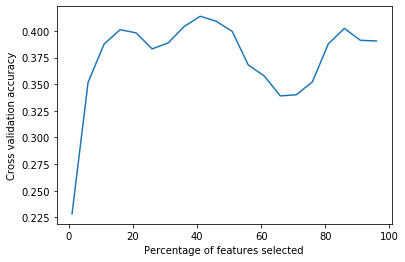

In [24]:
percentiles = range(1, 100, 5)
results = []
for i in range(1, 100, 5):
    fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=i)
    X_train_fs = fs.fit_transform(x, y)
    scores = model_selection.cross_val_score(linreg, X_train_fs, y, cv=5)
    print (i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = np.where(results == results.max())[0]
print(optimal_percentile[0])
print ("Optimal percentile of features:{0}".format(percentiles[optimal_percentile[0]]), "\n")
optimal_num_features = int(percentiles[optimal_percentile[0]]*len(xTarget.columns)/100)
print ("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

In [25]:
fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=41)
X_train_fs = fs.fit_transform(x, y)

The below table shows the important features selected for the model. Earnings, Revenue, Income and other features from the income statement have an impact on stock price just as balance sheet data of Assets and Equity. Additionally, Research and Development remained in the model, but Share Short was no longer considered an important feature.

The model is not perfect with an error in validation near 45. However, many aspects go into a stock's price that are not reflected in balance sheet and income statement data. For instance, a company could announce a new vaccine for a disease. This can have a material impact on stock price, but increased sales and revenue will not be experienced for several quarters. On the negative side, tariffs or boycotts can negatively impact a stock price before that impact is fully realized on financial statements.

The model does offer stocks for further research for an analyst. Large deviations between pridicted stock prices and actual prices could be an area requiring further research to make sure the price in the market reflects all known news.

In [26]:
for i in range(len(xTarget.columns.values)):
    if fs.get_support()[i]:
        print (xTarget.columns.values[i],'\t', fs.scores_[i])

Intangible Assets 	 462.1984842380316
Capital Surplus 	 263.1954735439674
Total Stockholder Equity 	 935.5561370003327
Total Assets 	 249.8667204788013
Retained Earnings 	 1221.2905534316508
Good Will 	 971.0721219985069
Treasury Stock 	 776.5634368414084
Cash 	 284.0225711002569
Other Stockholder Equity 	 302.20362306323966
Property Plant Equipment 	 392.78380732035504
Long Term Debt 	 262.8869298749185
Inventory 	 221.37344721264338
Net Income 	 369.26052670903573
Total Cash From Operating Activities 	 266.7246402896591
Depreciation 	 320.2925571692214
Dividends Paid 	 1409.1574426748014
Research Development 	 353.0264419735443
Income Before Tax 	 508.9782514040174
Selling General Administrative 	 710.3276275244559
Gross Profit 	 1747.1839608105097
Ebit 	 1263.3416989400635
Operating Income 	 1261.990056703766
Interest Expense 	 267.74441059162916
Total Revenue 	 604.6925931431941
Total Operating Expenses 	 472.0857156047714
Cost Of Revenue 	 317.4590535081692
Net Income From Continu

Both Ridge and Lasso regressions are performed to further test the model. Here, errors are compared with the linear regression model above to see how significantly the error changes when penalizing for overfitting and reduced feature selection.

The RMSE on the linear regression was 40 and near 45 after cross validation. The RMSE for the ridge regression is shown at 44 below. The RMSE on the lasso regression is shown below to also be 44. The error did not significantly change amongst models.

### Ridge Regression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [28]:
def modelTraining(x, y, alpha, modelType):
    print('Method: %s' %modelType.__name__)
    
    n = 5
    t_rmse = np.array([])
    cv_rmse = np.array([])
    minAlpha = alpha[0]
    
    for a in alpha:
        model = modelType(alpha=a)
        model.fit(x,y)
        p = model.predict(x)
        e = p-y
        total_error = np.dot(e,e)
        rmse_train = np.sqrt(total_error/len(p))

        #kf = KFold(len(x), n_folds=5)
        kf = KFold(n_splits=n)
        kf.get_n_splits(x)

        KFold(n_splits=n,random_state=None, shuffle=False)
        err = 0
        for train,test in kf.split(x):
            model.fit(x[train],y[train])
            p = model.predict(x[test])
            e = p-y[test]
            err += np.dot(e,e)
        rmse_5cv = np.sqrt(err/len(x))
        
        t_rmse = np.append(t_rmse, [rmse_train])
        cv_rmse = np.append(cv_rmse, [rmse_5cv])
        if (rmse_5cv <= np.amin(cv_rmse)):
            minAlpha = a
    
    print ('\nThe plot of training error vs cross validation error')
    pl.plot(alpha, t_rmse, label='RMSE-Train')
    pl.plot(alpha, cv_rmse, label='RMSE_XVal')
    pl.legend( ('RMSE-Train', 'RMSE_XVal') )
    pl.ylabel('RMSE')
    pl.xlabel('Alpha')
    pl.show()
    
    print ("The model with lowest cv error has alpha value of: ", minAlpha)
    model = modelType(alpha = minAlpha)
    model.fit(x, y)    
    p = model.predict(X_test)
    e = p-y_test
    total_error = np.dot(e,e)
    rmse_test = np.sqrt(total_error/len(p))
    print ("\nThe RMSE on the test set with alpha for min error is: ", rmse_test)

In [29]:
alpha = np.linspace(.01,20,50)

Method: Ridge

The plot of training error vs cross validation error


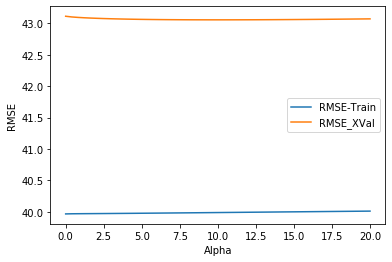

The model with lowest cv error has alpha value of:  9.801020408163264

The RMSE on the test set with alpha for min error is:  43.95314941293063


In [30]:
modelTraining(X_train, y_train, alpha, Ridge)

### Lasso Regression

Method: Lasso

The plot of training error vs cross validation error


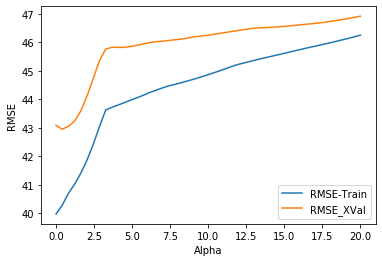

The model with lowest cv error has alpha value of:  0.41795918367346935

The RMSE on the test set with alpha for min error is:  43.53120299572139


In [31]:
import warnings
warnings.filterwarnings('ignore')
modelTraining(X_train, y_train, alpha, Lasso)

### Regression Models using 'Next Quarter Return' as target variable

In [32]:
# create a random state variable
RANDOM_STATE = 42

These models used a slightly different feature set that included TFxIDF bigrams from the business summary of each stock

In [33]:
# import csv
csv_file = 'outlier_removed_processed_df_bigrams.csv'
stock_df = pd.read_csv(csv_file, index_col=0)

In [34]:
# sort on quarter
stock_df.sort_values(by='Qtr', ascending=True, inplace=True)

In [35]:
# drop features needed only for classification
stock_df_reg = stock_df.drop(columns=['Entire Market Return', 'Outlier Removed Market Return', 'Beat Entire Market Return', 'Beat Outlier Removed Market Return'])

In [36]:
# split data into features and target
features = stock_df_reg.drop(columns='Next Qtr Return')
target = stock_df_reg['Next Qtr Return']

In [37]:
# get index of qtr changes
qtr_counts = features['Qtr'].value_counts().sort_index(ascending=True).cumsum()
qtr_train_index = round(qtr_counts*.85).astype(int)

Here we have to be careful with how we split the train and test data.  Since the data we have is based on a time series, it would be inappropriate to have test data that precedes in time the training data.  We handle that by creating a custom CV split that creates training and test splits based off the information that was known at the time of the stock instance.  When we test the model we do so by testing the results from each quarter with the most recent quarter using the information of all quarters previous.

In [38]:
# create custom time series split by quarter
my_cv = [
    (np.arange(0, qtr_train_index[0]-1), np.arange(qtr_train_index[0], qtr_counts[0]-1)),
    (np.arange(0, qtr_train_index[1]-1), np.arange(qtr_train_index[1], qtr_counts[1]-1)),
    (np.arange(0, qtr_train_index[2]-1), np.arange(qtr_train_index[2], qtr_counts[2]-1)),
    (np.arange(0, qtr_train_index[3]-1), np.arange(qtr_train_index[3], qtr_counts[3]))
]

In [39]:
# don't use qtr as a feature
features.drop(columns='Qtr', inplace=True)

In [40]:
# standard scale data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [41]:
# create a function that takes a model and outputs the test results
def model_train_test(model, inp_params, model_name):
    scores = []
    best_model = model
    for q_num, (train, test) in enumerate(my_cv):
        if q_num == 0:
            qtr = '2019_Q2'
        elif q_num == 1:
            qtr = '2019_Q3'
        elif q_num == 2:
            qtr = '2019_Q4'
        else:
            qtr = '2020_Q1'

        qtr_f_train = features_scaled[train]
        qtr_f_test = features_scaled[test]
        qtr_t_train = target[train]
        qtr_t_test = target[test]

        # set up gridsearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=inp_params, scoring='neg_mean_squared_error')

        _ = grid_search.fit(qtr_f_train, qtr_t_train)

        print(grid_search.best_params_)
        best_model = grid_search.best_estimator_

        pred_train = best_model.predict(qtr_f_train)
        train_scores = (np.sqrt(mean_squared_error(qtr_t_train, pred_train)),r2_score(qtr_t_train, pred_train))
        print('{} RMSE on train set through {} is: {}'.format(model_name, qtr, train_scores[0]))
        print('{} R^2 on train set through {} is: {}'.format(model_name, qtr, train_scores[1]))

        pred_test = best_model.predict(qtr_f_test)
        test_scores = (np.sqrt(mean_squared_error(qtr_t_test, pred_test)),r2_score(qtr_t_test, pred_test))
        print('{} RMSE on test set through {} is: {}'.format(model_name, qtr, test_scores[0]))
        print('{} R^2 on test set through {} is: {}'.format(model_name, qtr, test_scores[1]))

        print('Number of features with a coefficient of 0 in {} is {}'.format(model_name, len(best_model.coef_[best_model.coef_ == 0])))

        scores.append((train_scores, test_scores))

    return best_model, scores

### Ridge Regression for Return

In [42]:
# initialize ridge reg
ridge_reg = Ridge(random_state=RANDOM_STATE)

# set parameter possibilities
params = {'alpha' : [100, 500, 1000, 5000, 10000, 50000]}

ridge_reg, ridge_reg_scores = model_train_test(ridge_reg, params, 'Ridge Regression')

{'alpha': 5000}
Ridge Regression RMSE on train set through 2019_Q2 is: 15.303273332496344
Ridge Regression R^2 on train set through 2019_Q2 is: 0.26034782774049003
Ridge Regression RMSE on test set through 2019_Q2 is: 18.02993328962153
Ridge Regression R^2 on test set through 2019_Q2 is: 0.044243929430618056
Number of features with a coefficient of 0 in Ridge Regression is 2
{'alpha': 50000}
Ridge Regression RMSE on train set through 2019_Q3 is: 21.23127370233343
Ridge Regression R^2 on train set through 2019_Q3 is: 0.027988885889325354
Ridge Regression RMSE on test set through 2019_Q3 is: 18.595066685123644
Ridge Regression R^2 on test set through 2019_Q3 is: -0.06740031315861894
Number of features with a coefficient of 0 in Ridge Regression is 2
{'alpha': 5000}
Ridge Regression RMSE on train set through 2019_Q4 is: 23.77496128705354
Ridge Regression R^2 on train set through 2019_Q4 is: 0.15958377471391472
Ridge Regression RMSE on test set through 2019_Q4 is: 35.43948922541107
Ridge R

### Lasso Regression for Return

In [43]:
# initialize lasso reg
lasso_reg = Lasso(random_state=RANDOM_STATE, max_iter=5000, tol=1e-3)

# set parameter possibilities
params = {'alpha' : [.5, .75, 1, 1.25, 1.5, 2],
          'fit_intercept' : [True, False]}

lasso_reg, lasso_reg_scores = model_train_test(lasso_reg, params, 'Lasso Regression')

{'alpha': 1, 'fit_intercept': True}
Lasso Regression RMSE on train set through 2019_Q2 is: 15.688331787594842
Lasso Regression R^2 on train set through 2019_Q2 is: 0.22265752720917176
Lasso Regression RMSE on test set through 2019_Q2 is: 17.975921762776156
Lasso Regression R^2 on test set through 2019_Q2 is: 0.04996159051351867
Number of features with a coefficient of 0 in Lasso Regression is 696
{'alpha': 1, 'fit_intercept': True}
Lasso Regression RMSE on train set through 2019_Q3 is: 20.275676461747405
Lasso Regression R^2 on train set through 2019_Q3 is: 0.11351817123194097
Lasso Regression RMSE on test set through 2019_Q3 is: 17.791402819374785
Lasso Regression R^2 on test set through 2019_Q3 is: 0.022870261397527236
Number of features with a coefficient of 0 in Lasso Regression is 722
{'alpha': 1.5, 'fit_intercept': False}
Lasso Regression RMSE on train set through 2019_Q4 is: 24.69130385909725
Lasso Regression R^2 on train set through 2019_Q4 is: 0.09355211564945798
Lasso Regress

### Elastic Net Regression for Return

In [44]:
# initialize elastic net reg
elastic_reg = ElasticNet(random_state=RANDOM_STATE, max_iter=5000, tol=.5)

# set parameter possibilities
params = {'alpha' : [.5, 1, 5, 10],
          'l1_ratio' : [0, .33, .66, 1]}

elastic_reg, elastic_reg_scores = model_train_test(elastic_reg, params, 'Elastic Net Regression')

{'alpha': 5, 'l1_ratio': 0}
Elastic Net Regression RMSE on train set through 2019_Q2 is: 15.248061547537649
Elastic Net Regression R^2 on train set through 2019_Q2 is: 0.2656752956813896
Elastic Net Regression RMSE on test set through 2019_Q2 is: 18.05582654798107
Elastic Net Regression R^2 on test set through 2019_Q2 is: 0.041496785685649296
Number of features with a coefficient of 0 in Elastic Net Regression is 5
{'alpha': 1, 'l1_ratio': 1}
Elastic Net Regression RMSE on train set through 2019_Q3 is: 20.27095801709448
Elastic Net Regression R^2 on train set through 2019_Q3 is: 0.11393071763963081
Elastic Net Regression RMSE on test set through 2019_Q3 is: 17.791723894438878
Elastic Net Regression R^2 on test set through 2019_Q3 is: 0.022834993259591152
Number of features with a coefficient of 0 in Elastic Net Regression is 719
{'alpha': 1, 'l1_ratio': 1}
Elastic Net Regression RMSE on train set through 2019_Q4 is: 24.28515902648033
Elastic Net Regression R^2 on train set through 2019

### SGD Regression for Return

In [45]:
# initialize SGD reg
sgd_reg = SGDRegressor(random_state=RANDOM_STATE, max_iter=5000)

# set parameter possibilities
params = {'alpha' : [.1, .5, 1],
          'l1_ratio' : [0, .1, .5, 1],
          'penalty' : ['l1', 'l2']}

sgd_reg, sgd_reg_scores = model_train_test(sgd_reg, params, 'SGD Regression')

{'alpha': 1, 'l1_ratio': 0, 'penalty': 'l1'}
SGD Regression RMSE on train set through 2019_Q2 is: 15.659050981706438
SGD Regression R^2 on train set through 2019_Q2 is: 0.22555649359036323
SGD Regression RMSE on test set through 2019_Q2 is: 17.925227342853116
SGD Regression R^2 on test set through 2019_Q2 is: 0.05531249665102811
Number of features with a coefficient of 0 in SGD Regression is 705
{'alpha': 1, 'l1_ratio': 0, 'penalty': 'l1'}
SGD Regression RMSE on train set through 2019_Q3 is: 20.330574887652926
SGD Regression R^2 on train set through 2019_Q3 is: 0.10871119556927322
SGD Regression RMSE on test set through 2019_Q3 is: 17.862711501079968
SGD Regression R^2 on test set through 2019_Q3 is: 0.015021811216352376
Number of features with a coefficient of 0 in SGD Regression is 728
{'alpha': 1, 'l1_ratio': 0, 'penalty': 'l2'}
SGD Regression RMSE on train set through 2019_Q4 is: 24.529135516914163
SGD Regression R^2 on train set through 2019_Q4 is: 0.1054198100573307
SGD Regressio

In [46]:
# convert to arrays to create table of scores
ridge_reg_train_scores = np.asarray(ridge_reg_scores)[:,0]
ridge_reg_test_scores = np.asarray(ridge_reg_scores)[:,1]
lasso_reg_train_scores = np.asarray(lasso_reg_scores)[:,0]
lasso_reg_test_scores = np.asarray(lasso_reg_scores)[:,1]
elastic_reg_train_scores = np.asarray(elastic_reg_scores)[:,0]
elastic_reg_test_scores = np.asarray(elastic_reg_scores)[:,1]
sgd_reg_train_scores = np.asarray(sgd_reg_scores)[:,0]
sgd_reg_test_scores = np.asarray(sgd_reg_scores)[:,1]

In [47]:
# create dict all regression scores
reg_score_dictionary = {'Ridge' : (ridge_reg_train_scores.mean(axis=0), ridge_reg_test_scores.mean(axis=0)), 'Lasso ' : (lasso_reg_train_scores.mean(axis=0), lasso_reg_test_scores.mean(axis=0) ), 'El. Net' : (elastic_reg_train_scores.mean(axis=0), elastic_reg_test_scores.mean(axis=0) ), 'SGD' : (sgd_reg_train_scores.mean(axis=0), sgd_reg_test_scores.mean(axis=0) )}

In [48]:
### Comparison of Regression Models for Return

In [49]:
print('\t\t\tScores')
print('\t\tTrain\t\tTest')
for type in reg_score_dictionary:
    print('{}\t\tRMSE | {}\t| {}'.format(type, round(reg_score_dictionary[type][0][0],4), round(reg_score_dictionary[type][1][0],4)))
    print('\t\tR^2  | {}\t| {}'.format(round(reg_score_dictionary[type][0][1],4), round(reg_score_dictionary[type][1][1],4)))

			Scores
		Train		Test
Ridge		RMSE | 21.4487	| 26.094
		R^2  | 0.162	| -0.1846
Lasso 		RMSE | 21.6484	| 25.8581
		R^2  | 0.1503	| -0.1647
El. Net		RMSE | 21.3081	| 25.5262
		R^2  | 0.1766	| -0.1326
SGD		RMSE | 21.6619	| 25.9758
		R^2  | 0.1498	| -0.171


### Visualize the best regression model (Elastic Net Regression)

In [50]:
coef = pd.Series(elastic_reg.coef_, features.columns).sort_values()

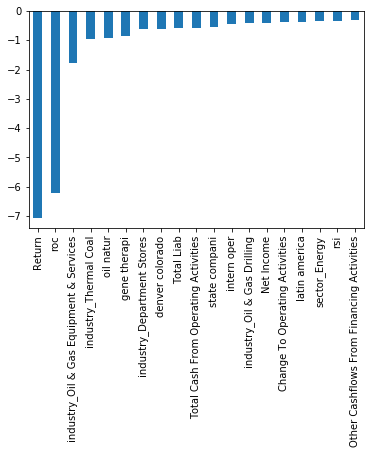

In [51]:
_ = coef[:19].plot(kind='bar')

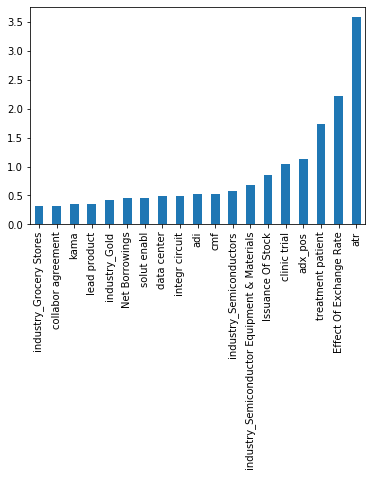

In [52]:
_ = coef[-19:].plot(kind='bar')

In [53]:
print('All Relevant Features:')
coef[coef != 0]

All Relevant Features:


Return                                         -7.069515
roc                                            -6.218446
industry_Oil & Gas Equipment & Services        -1.780888
industry_Thermal Coal                          -0.956257
oil natur                                      -0.909194
gene therapi                                   -0.869445
industry_Department Stores                     -0.631610
denver colorado                                -0.623508
Total Liab                                     -0.593344
Total Cash From Operating Activities           -0.572190
state compani                                  -0.554123
intern oper                                    -0.450563
industry_Oil & Gas Drilling                    -0.402761
Net Income                                     -0.395635
Change To Operating Activities                 -0.391128
latin america                                  -0.375765
sector_Energy                                  -0.351924
rsi                            

In [54]:
def checkReturn(pred_vals, true_vals, qtr):
    # see what hypothetical return would be by picking stocks that were predicted to have positive returns
    stocks_taken = []
    for i, ret_val in enumerate(pred_vals):
        if ret_val > 0:
            stocks_taken.append(true_vals[i])

    our_return = round(sum(stocks_taken) / len(stocks_taken),2)
    market_return = round(np.mean(true_vals),2)

    print('\n{}:'.format(qtr))
    print('\tTotal return of all positive predicted return stocks:   {}'.format(our_return))
    print('\tTotal return of all stocks in test set: \t\t{}'.format(market_return))
    print('\tReturn over market based on best model: \t\t{}\n'.format(round(our_return - market_return,2)))
    return round((our_return - market_return),2)

#### Get results of Elastic Net Regression and what it means in terms of model performance.


2019_Q2:
	Total return of all positive predicted return stocks:   0.19
	Total return of all stocks in test set: 		-5.17
	Return over market based on best model: 		5.36



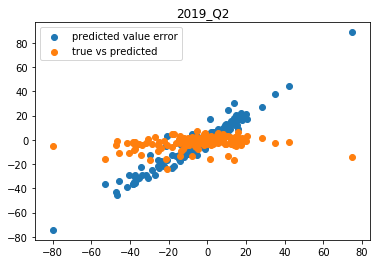

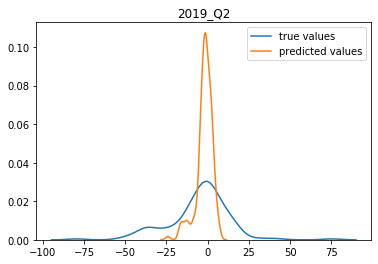


2019_Q3:
	Total return of all positive predicted return stocks:   9.36
	Total return of all stocks in test set: 		9.04
	Return over market based on best model: 		0.32



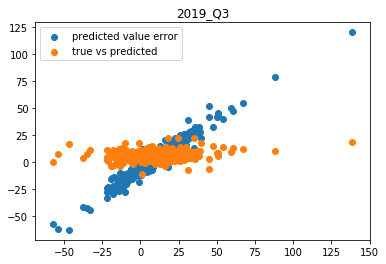

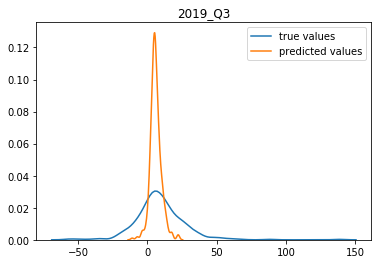


2019_Q4:
	Total return of all positive predicted return stocks:   -13.88
	Total return of all stocks in test set: 		-27.86
	Return over market based on best model: 		13.98



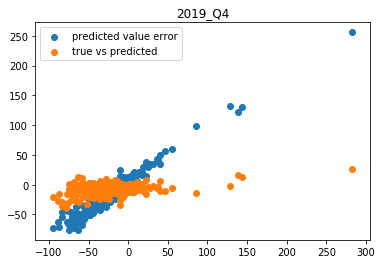

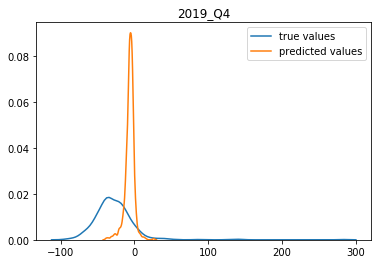


2020_Q1:
	Total return of all positive predicted return stocks:   18.37
	Total return of all stocks in test set: 		16.54
	Return over market based on best model: 		1.83



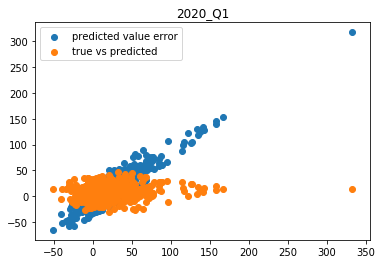

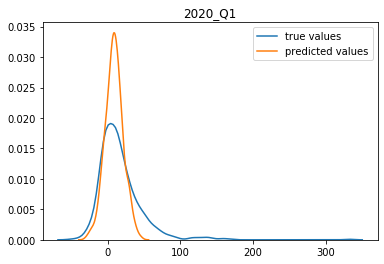

Overall return over market: 5.37


In [55]:
return_over_market = 0
for q_num, (train, test) in enumerate(my_cv):
    if q_num == 0:
        qtr = '2019_Q2'
    elif q_num == 1:
        qtr = '2019_Q3'
    elif q_num == 2:
        qtr = '2019_Q4'
    else:
        qtr = '2020_Q1'

    qtr_f_train = features_scaled[train]
    qtr_f_test = features_scaled[test]
    qtr_t_train = target[train]
    qtr_t_test = target[test]

    # initialize elastic net reg
    elastic_reg = ElasticNet(random_state=RANDOM_STATE, max_iter=5000, tol=.5)

    # set parameter possibilities
    params = {'alpha' : [.5, 1, 5, 10],
              'l1_ratio' : [0, .33, .66, 1]}

     # set up gridsearchCV
    grid_search = GridSearchCV(estimator=elastic_reg, param_grid=params, scoring='neg_mean_squared_error')

    _ = grid_search.fit(qtr_f_train, qtr_t_train)

    elastic_reg = grid_search.best_estimator_
    pred_test = elastic_reg.predict(qtr_f_test)

    return_over_market += checkReturn(pred_test, qtr_t_test, qtr)

    fig, ax = plt.subplots()
    _ = ax.scatter(qtr_t_test, (qtr_t_test - pred_test), label='predicted value error')
    _ = ax.scatter(qtr_t_test, pred_test, label='true vs predicted')
    _ = plt.legend()
    _ = plt.title('{}'.format(qtr))
    plt.show()


    _ = sns.kdeplot(qtr_t_test, label='true values')
    _ = sns.kdeplot(pred_test, label='predicted values')
    _ = plt.legend()
    _ = plt.title('{}'.format(qtr))
    plt.show()

print('Overall return over market: {}'.format(round(return_over_market / 4,2)))

We are happy with the results of this regression model because it shows a positive return over the market.  Many, if not all, hedge funds would be satisfied with a 5.37% return over market.  The elastic net model ended up using quite a bit of normalization with a l1_ratio of 1 and kept the number of features used to only 126.  This is unsurprising in the unpredictable world of stock returns.  The features with high coefficients included a mix of industry, sector, technical indicators, fundamental indicators and even TFxIDF bigrams.  This is good news as it means the entire dataset was applicable in some way and was worth the effort to create it.

### KNN, Kmeans, Bayes, Decision Trees and Linear Discriminent Analysis

Often times valuation of a company is measured as the price of the stock per book value of the company. Using assets and liabilities, a company's book value is their assets minus their liabilities. The price given this book value can be compared across stocks in the same industry. Stocks with a price to book greater than the median for that industry can be deemed expensive, while those with a price to book below the median can be thought of as cheap. A classifier can potentially tell us whether a stock is cheap or expensive based on this measure. 

In [57]:
data = pd.read_csv("stock_complete_info.csv", sep=',').fillna(0)

Data is again read in. Book Value and price to book are calculated for each stock. Some values were not available and others had a negative book value. These instances were dropped from the dataset.

In [58]:
data['bookValue'] = data['Total Assets'] - data['Total Liab'] - data['Intangible Assets']
data['PricetoBook'] = data['Close'] / (data['bookValue'] / data['sharesOutstanding'])
data.shape

(7648, 106)

In [59]:
data = data.replace([np.inf, -np.inf], np.nan).dropna()

In [60]:
indexNames = data[data['PricetoBook'] <= 0].index
data.drop(indexNames, inplace=True)
data.shape

(7012, 106)

As before, outliers were removed.

In [61]:
q_low = data['PricetoBook'].quantile(0.01)
q_hi  = data['PricetoBook'].quantile(0.99)

dataExOutliers = data[(data['PricetoBook'] < q_hi) & (data['PricetoBook'] > q_low)]
dataExOutliers.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,Repurchase Of Stock,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,country,industry,longBusinessSummary,sector,sharesOutstanding,sharesShort,Return,aoi,kama,roc,rsi,tsi,adi,cmf,emi,atr,bband_h,bband_l,adx_pos,adx_neg,macd,Short Term Investments,Deferred Long Term Liab,Qtr,Entire Market Return,Outlier Removed Market Return,Beat Entire Market Return,Beat Outlier Removed Market Return,bookValue,PricetoBook
0,A 2019_Q2,2019-04-30,76.75,77.89,76.69,77.80,1726200.0,0.0,0.0,1.059000e+09,5.293000e+09,4.653000e+09,4.848000e+09,415000000.0,9.501000e+09,3000000.0,204000000.0,73000000.0,8.330000e+08,3.589000e+09,-5.210000e+08,5.980000e+08,1.226000e+09,1.892000e+09,-5.210000e+08,1.035000e+09,3.102000e+09,1.180000e+08,2.000000e+08,966000000.0,1.787000e+09,7.060000e+08,3.290000e+08,0.0,0.0,-1000000.0,-15000000.0,-3.500000e+07,56000000.0,-61000000.0,-275000000.0,32000000.0,197000000.0,-156000000.0,-93000000.0,-1000000.0,-59000000.0,79000000.0,-56000000.0,-32000000.0,-40000000.0,27000000.0,-34000000.0,0.0,0.0,104000000.0,0.0,219000000.0,0.000000e+00,389000000.0,723000000.0,230000000.0,230000000.0,0.0,-20000000.0,0.0,0.0,0.0,22000000.0,1.357000e+09,1.127000e+09,6.340000e+08,-11000000.0,0.0,197000000.0,197000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,-6.917019,-2.619706,76.215598,-3.173615,50.321067,-12.902244,1.451059e+07,-0.135524,7.299270,1.521994,0.0,0.0,14.867414,29.279115,-0.610567,0.0,0.0,2019_Q2,2.110926,1.502301,0,0,3.789000e+09,6.358102
1,A 2019_Q3,2019-07-31,69.71,70.18,68.45,68.94,3846100.0,0.0,0.0,1.107000e+09,5.277000e+09,4.704000e+09,4.748000e+09,666000000.0,9.452000e+09,3000000.0,130000000.0,-18000000.0,8.330000e+08,3.593000e+09,-5.140000e+08,6.110000e+08,1.382000e+09,2.080000e+09,-5.140000e+08,8.500000e+08,3.189000e+09,1.020000e+08,4.800000e+07,998000000.0,1.786000e+09,6.790000e+08,3.540000e+08,410000000.0,0.0,-2000000.0,29000000.0,-1.193000e+09,600000000.0,497000000.0,23000000.0,2000000.0,194000000.0,-383000000.0,-50000000.0,-1000000.0,314000000.0,76000000.0,-51000000.0,-5000000.0,-48000000.0,45000000.0,-30000000.0,-1000000.0,-4000000.0,102000000.0,0.0,231000000.0,0.000000e+00,322000000.0,737000000.0,313000000.0,313000000.0,0.0,-21000000.0,0.0,0.0,0.0,37000000.0,1.367000e+09,1.054000e+09,6.300000e+08,-82000000.0,0.0,194000000.0,194000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,3.067090,-2.039000,69.517929,-1.612673,41.318386,-14.191339,2.075694e+07,-0.038812,29.012506,1.366337,0.0,0.0,17.365258,27.167584,-0.

The histogram below shows the price to book for each stock remaining in the dataset. Many stocks have a p/b less than five, but several are much greater. What will be important to review, is how stocks compare among stocks in the same industry.

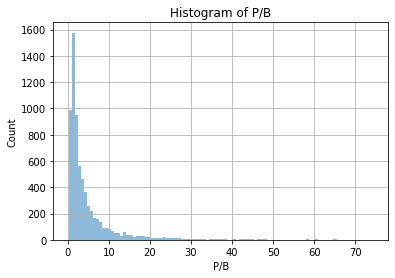

In [62]:
plt.hist(dataExOutliers['PricetoBook'], bins=100, alpha=0.5)
plt.xlabel('P/B')
plt.ylabel('Count')
plt.title('Histogram of P/B')
plt.grid(True)
plt.show()

The median p/b for each industry is calculated below. This median value is then added to the dataset. Further, the median is subtracted from each stock's p/b. If the result is postive, a classification of 1 is assigned to the stock. If the value is negative, meaning cheap, it is assigned a zero for classification purposes. 

The dataset is then reduced in features and recalculated for all measures to be on a per share basis.

In [63]:
m = dataExOutliers.groupby(['industry'])[['PricetoBook']].apply(np.median)

In [64]:
m.name = 'MedianP/BPerIndustry'
m

industry
Advertising Agencies                       4.119569
Aerospace & Defense                        3.511808
Agricultural Inputs                        1.057431
Airlines                                   1.603545
Airports & Air Services                    0.812967
Aluminum                                   0.917447
Apparel Manufacturing                      2.927097
Apparel Retail                             1.770052
Asset Management                           2.305211
Auto & Truck Dealerships                   1.940431
Auto Manufacturers                         2.661272
Auto Parts                                 2.142634
Banks—Diversified                          1.037947
Banks—Regional                             1.156839
Beverages—Brewers                          4.662425
Beverages—Non-Alcoholic                   12.230276
Biotechnology                              4.196949
Broadcasting                               1.141818
Building Materials                         2.616044
Bui

In [65]:
dataExOutliers = dataExOutliers.join(m, on=['industry'])

In [66]:
dataExOutliers['OverUnderPrice'] = np.sign(dataExOutliers['PricetoBook'] - dataExOutliers['MedianP/BPerIndustry'])
dataExOutliers['OverUnderPrice'] = dataExOutliers['OverUnderPrice'].where(dataExOutliers['OverUnderPrice'] != -1, 0)

In [67]:
dataExOutliers = dataExOutliers.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 
                            'Stock Splits', 'longBusinessSummary', 'country', 'industry', 'sector',
                                      'Qtr', 'Entire Market Return', 'Outlier Removed Market Return',
                                     'Beat Entire Market Return', 'Beat Outlier Removed Market Return',
                                     'bookValue', 'PricetoBook', 'MedianP/BPerIndustry'], axis=1)

In [68]:
dataExOutliers.iloc[:, 1:68] = dataExOutliers.iloc[:,1:68].div(dataExOutliers.sharesOutstanding, axis=0)
dataExOutliers.iloc[:, [69,86,87]] = dataExOutliers.iloc[:, [69,86,87]].div(dataExOutliers.sharesOutstanding, axis=0)

In [69]:
dataExOutliers = dataExOutliers.drop(['sharesOutstanding'], axis=1)

In [70]:
dataExOutliers = dataExOutliers.iloc[:, 1:]

In [71]:
dataExOutliers.head(10)

,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,Repurchase Of Stock,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,sharesShort,Return,aoi,kama,roc,rsi,tsi,adi,cmf,emi,atr,bband_h,bband_l,adx_pos,adx_neg,macd,Short Term Investments,Deferred Long Term Liab,OverUnderPrice
0,3.419979,17.093437,15.026594,15.656335,1.340218,30.682929,0.009688,0.658806,0.235749,2.690125,11.590468,-1.682539,1.931206,3.959296,6.110104,-1.682539,3.342473,10.017729,0.381074,0.645888,3.119641,5.771013,2.279986,1.062486,0.000000,0.000000,-0.003229,-0.048442,-0.113030,0.180849,-0.196996,-0.888097,0.103342,0.636200,-0.503793,-0.300338,-0.003229,-0.190537,0.255126,-0.180849,-0.103342,-0.129178,0.087195,-0.109801,0.000000,0.000000,0.335862,0.0,0.707248,0.000000,1.256253,2.334887,0.742772,0.742772,0.000000,-0.064589,0.0,0.0,0.0,0.071048,4.382353,3.639581,2.047466,-0.035524,0.0,0.636200,0.636200,0.016981,-6.917019,-2.619706,76.215598,-3.173615,50.321067,-12.902244,1.451059e+07,-0.135524,7.299270,1.521994,0.0,0.0,14.867414,29.279115,-0.610567,0.0,0.0,0.0
1,3.574992,17.041766,15.191296,15.333391,2.150808,30.524687,0.009688,0.419827,-0.058130,2.690125,11.603385,-1.659933,1.973189,4.463089,6.717240,-1.659933,2.745026,10.298691,0.329403,0.155013,3.222983,5.767784,2.192791,1.143223,1.324071,0.000000,-0.006459,0.093654,-3.852724,1.937665,1.605033,0.074277,0.006459,0.626512,-1.236876,-0.161472,-0.003229,1.014045,0.245438,-0.164702,-0.016147,-0.155013,0.145325,-0.096883,-0.003229,-0.012918,0.329403,0.0,0.746001,0.000000,1.039880,2.380099,1.010815,1.010815,0.000000,-0.067818,0.0,0.0,0.0,0.119489,4.414647,3.403832,2.034549,-0.264814,0.0,0.626512,0.626512,0.016981,3.067090,-2.039000,69.517929,-1.612673,41.318386,-14.191339,2.075694e+07,-0.038812,29.012506,1.366337,0.0,0.0,17.365258,27.167584,-0.590718,0.0,0.0,0.0
2,1.650245,17.019160,12.523776,15.330162,1.230417,27.853938,0.009688,0.568382,-0.393992,3.106723,10.033877,-1.304695,1.976419,5.699965,5.238155,-1.304695,2.709502,11.164181,0.319715,3.646040,2.764402,4.178898,2.131432,1.020504,0.000000,1.627639,-0.009688,0.025836,-0.164702,1.937665,-1.879535,0.032294,0.061359,0.616823,-1.259482,-1.776193,0.003229,0.781525,0.177619,-0.164702,-0.032294,-0.132407,0.093654,-0.151784,-0.003229,-0.012918,0.326174,0.0,0.716936,0.000000,1.101240,2.234774,0.807361,0.807361,0.000000,-0.058130,0.0,0.0,0.0,0.100113,4.114309,3.306949,1.879535,-0.090424,0.0,0.616823,0.616823,0.016981,11.563265,0.087441,75.035474,0.000000,53.942382,6.623598,1.926595e+07,-0.004604,-8.933539,1.355502,0.0,0.0,24.899534,22.458885,0.276914,0.0,0.0,0.0
3,1.737440,17.254909,12.585136,16.550891,1.230417,29.136027,0.009688,0.584529,0.574841,3.168083,10.050024,-1.288547,2.057155,6.959448,3.610516,-1.285318,2.670749,12.310633,0

Next, the target classification feature is separated from the remaining dataset. Further, in order to use KNeighborsClassifier, 0 is renamed "Under" while 1 is renamed "Over" for each instance in the dataset. Labeling indicates "Under" priced or "Over" priced.  

In [72]:
dataExTarget = dataExOutliers.drop('OverUnderPrice', axis=1)
target = dataExOutliers['OverUnderPrice']

In [73]:
dataExTarget.reset_index(inplace = True, drop = True)
target.reset_index(inplace = True, drop = True)

In [74]:
for i in range(len(target)):
    if(target[i] == 0):
        target[i] ='Under'
    else:
        target[i] = 'Over'

The dataset is divided into separate training and testing sets. Further, data is scaled to normalize amongst stocks to make the classification more accurate. The first few in the training and testing sets are printed to show the zero to one range.

In [75]:
train, test, target_train, target_test = train_test_split(dataExTarget, target, test_size=0.2, random_state=33)

print ("data frame shapes to make sure splits are correct")
print ("test shape:", test.shape)
print ("train shape:", train.shape)
print ("test targets shape:", target_test.shape)
print ("train targets shape:", target_train.shape)

data frame shapes to make sure splits are correct
test shape: (1374, 85)
train shape: (5496, 85)
test targets shape: (1374,)
train targets shape: (5496,)


In [76]:
min_max_scaler = preprocessing.MinMaxScaler().fit(train)
train_norm = min_max_scaler.transform(train)
test_norm = min_max_scaler.transform(test)

In [77]:
np.set_printoptions(precision=2, linewidth=80, suppress=True)
train_norm[0:5]

array([[0.  , 0.03, 0.  , 0.03, 0.  , 0.01, 0.01, 0.  , 0.02, 0.  , 0.  ,
        0.97, 0.  , 0.  , 0.  , 0.42, 0.09, 0.  , 0.  , 0.16, 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.54, 0.4 , 0.61, 0.49, 0.33, 0.63, 0.  ,
        0.6 , 0.44, 1.  , 0.69, 0.62, 0.17, 0.98, 0.44, 0.77, 0.28, 0.94,
        0.74, 0.53, 0.01, 0.  , 0.62, 0.05, 0.01, 0.38, 0.62, 0.62, 0.15,
        0.98, 0.  , 0.  , 0.  , 0.79, 0.03, 0.01, 0.09, 0.64, 0.19, 0.59,
        0.59, 0.04, 0.11, 0.82, 0.01, 0.14, 0.45, 0.39, 0.43, 0.53, 0.74,
        0.01, 0.  , 0.  , 0.22, 0.29, 0.9 , 0.  , 0.  ],
       [0.06, 0.07, 0.02, 0.04, 0.  , 0.02, 0.01, 0.01, 0.02, 0.  , 0.11,
        0.97, 0.  , 0.02, 0.  , 0.4 , 0.07, 0.01, 0.  , 0.12, 0.01, 0.05,
        0.02, 0.  , 0.  , 0.  , 0.54, 0.4 , 0.61, 0.49, 0.33, 0.63, 0.  ,
        0.59, 0.44, 1.  , 0.69, 0.61, 0.15, 1.  , 0.44, 0.77, 0.28, 0.94,
        0.74, 0.53, 0.01, 0.  , 0.61, 0.03, 0.04, 0.4 , 0.62, 0.62, 0.15,
        0.9 , 0.  , 0.  , 0.  , 0.78, 0.06, 0.05, 0.12,

In [78]:
train_norm[0:5]

array([[0.  , 0.03, 0.  , 0.03, 0.  , 0.01, 0.01, 0.  , 0.02, 0.  , 0.  ,
        0.97, 0.  , 0.  , 0.  , 0.42, 0.09, 0.  , 0.  , 0.16, 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.54, 0.4 , 0.61, 0.49, 0.33, 0.63, 0.  ,
        0.6 , 0.44, 1.  , 0.69, 0.62, 0.17, 0.98, 0.44, 0.77, 0.28, 0.94,
        0.74, 0.53, 0.01, 0.  , 0.62, 0.05, 0.01, 0.38, 0.62, 0.62, 0.15,
        0.98, 0.  , 0.  , 0.  , 0.79, 0.03, 0.01, 0.09, 0.64, 0.19, 0.59,
        0.59, 0.04, 0.11, 0.82, 0.01, 0.14, 0.45, 0.39, 0.43, 0.53, 0.74,
        0.01, 0.  , 0.  , 0.22, 0.29, 0.9 , 0.  , 0.  ],
       [0.06, 0.07, 0.02, 0.04, 0.  , 0.02, 0.01, 0.01, 0.02, 0.  , 0.11,
        0.97, 0.  , 0.02, 0.  , 0.4 , 0.07, 0.01, 0.  , 0.12, 0.01, 0.05,
        0.02, 0.  , 0.  , 0.  , 0.54, 0.4 , 0.61, 0.49, 0.33, 0.63, 0.  ,
        0.59, 0.44, 1.  , 0.69, 0.61, 0.15, 1.  , 0.44, 0.77, 0.28, 0.94,
        0.74, 0.53, 0.01, 0.  , 0.61, 0.03, 0.04, 0.4 , 0.62, 0.62, 0.15,
        0.9 , 0.  , 0.  , 0.  , 0.78, 0.06, 0.05, 0.12,

The next steps peform KNN, Decision Tree, Naive Bayes and Linear Discriminant Analysis classifications.

### KNN Classification

Both n=5 and n=10 were used for neighbors. Overall, it was more accurate with n=10. Uniform had a higher accuracy for Over, but worse for Under. Therefore, the final model used n=10 and weight=distance.

In [79]:
n_neighbors = 10

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(train_norm, target_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [80]:
knnpreds_test = knnclf.predict(test_norm)

In [81]:
print(classification_report(target_test, knnpreds_test))

              precision    recall  f1-score   support

        Over       0.61      0.61      0.61       669
       Under       0.63      0.63      0.63       705

    accuracy                           0.62      1374
   macro avg       0.62      0.62      0.62      1374
weighted avg       0.62      0.62      0.62      1374



In [82]:
knncm = confusion_matrix(target_test, knnpreds_test)
print (knncm)

[[407 262]
 [261 444]]


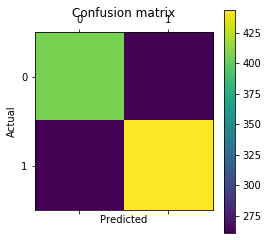

In [83]:
plt.matshow(knncm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Naive Bayes Classification

In [84]:
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(train, target_train)
nbpreds_test = nbclf.predict(test)

In [85]:
print(classification_report(target_test, nbpreds_test))

              precision    recall  f1-score   support

        Over       0.61      0.07      0.13       669
       Under       0.52      0.95      0.67       705

    accuracy                           0.53      1374
   macro avg       0.57      0.51      0.40      1374
weighted avg       0.56      0.53      0.41      1374



In [86]:
nbcm = confusion_matrix(target_test, nbpreds_test)
print (nbcm)

[[ 50 619]
 [ 32 673]]


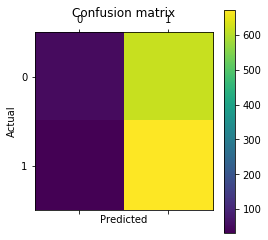

In [87]:
plt.matshow(nbcm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Linear Discriminant Analysis Classification

In [88]:
ldclf = LinearDiscriminantAnalysis()
ldclf = ldclf.fit(train, target_train)
ldpreds_test = ldclf.predict(test)

In [89]:
print(classification_report(target_test, ldpreds_test))

              precision    recall  f1-score   support

        Over       0.71      0.70      0.71       669
       Under       0.72      0.73      0.73       705

    accuracy                           0.72      1374
   macro avg       0.72      0.72      0.72      1374
weighted avg       0.72      0.72      0.72      1374



In [90]:
ldcm = confusion_matrix(target_test, ldpreds_test)
print(ldcm)

[[467 202]
 [188 517]]


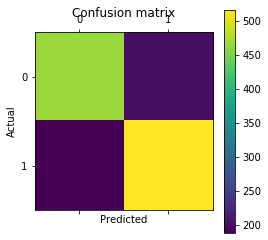

In [91]:
plt.matshow(ldcm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Decision Tree Classification

In [92]:
treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)

In [93]:
treeclf = treeclf.fit(train, target_train)

In [94]:
treepreds_test = treeclf.predict(test)

In [95]:
print(classification_report(target_test, treepreds_test))

              precision    recall  f1-score   support

        Over       0.76      0.77      0.77       669
       Under       0.78      0.77      0.78       705

    accuracy                           0.77      1374
   macro avg       0.77      0.77      0.77      1374
weighted avg       0.77      0.77      0.77      1374



In [96]:
treecm = confusion_matrix(target_test, treepreds_test)
print(treecm)

[[518 151]
 [161 544]]


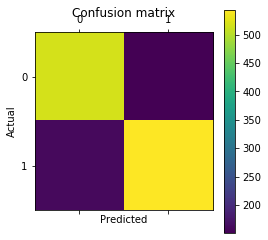

In [97]:
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

All four classifiers had a better than 50% accuracy rate on identifying whether a stock would be over or under priced based on price to book value for a stock. Where each stock's p/b was compared to the median for its industry. However, the decision tree classifier had the highest accuracy ratio 76% accuracy rate. LDA was not far behind with a 72% accuracy rate while KNN was 62% and Naive Bayes had an accuracy rate of 53%.

The findings here are interesting in that there is a high level of accuracy in determing whether a stock is over or under priced. In the event that the model is saying a stock should be over priced and it's actually under priced, an analyst could further research this a buying opportunity. If the model is classifying a stock as underpriced, but it is actually overpriced, an analyst should further research whether the stock should be sold.

Both the regression and classification models appear that they can be useful tools. An attempt to cluster stocks into the correct sector is shown below. This model was not effective for the 11 sectors and appears to be random.

### KMeans Clustering

Again, the process starts with preprocessing the dataset. This time, technical indicators were left in the datasest in the event that often, sectors will move together and stocks within sectors will exhibit similar moves in price.

In [98]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,Repurchase Of Stock,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,country,industry,longBusinessSummary,sector,sharesOutstanding,sharesShort,Return,aoi,kama,roc,rsi,tsi,adi,cmf,emi,atr,bband_h,bband_l,adx_pos,adx_neg,macd,Short Term Investments,Deferred Long Term Liab,Qtr,Entire Market Return,Outlier Removed Market Return,Beat Entire Market Return,Beat Outlier Removed Market Return,bookValue,PricetoBook
0,A 2019_Q2,2019-04-30,76.75,77.89,76.69,77.80,1726200.0,0.0,0.0,1.059000e+09,5.293000e+09,4.653000e+09,4.848000e+09,415000000.0,9.501000e+09,3000000.0,204000000.0,73000000.0,8.330000e+08,3.589000e+09,-5.210000e+08,5.980000e+08,1.226000e+09,1.892000e+09,-5.210000e+08,1.035000e+09,3.102000e+09,1.180000e+08,2.000000e+08,966000000.0,1.787000e+09,7.060000e+08,3.290000e+08,0.0,0.0,-1000000.0,-15000000.0,-3.500000e+07,56000000.0,-61000000.0,-275000000.0,32000000.0,197000000.0,-156000000.0,-93000000.0,-1000000.0,-59000000.0,79000000.0,-56000000.0,-32000000.0,-40000000.0,27000000.0,-34000000.0,0.0,0.0,104000000.0,0.0,219000000.0,0.000000e+00,389000000.0,723000000.0,230000000.0,230000000.0,0.0,-20000000.0,0.0,0.0,0.0,22000000.0,1.357000e+09,1.127000e+09,6.340000e+08,-11000000.0,0.0,197000000.0,197000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,-6.917019,-2.619706,76.215598,-3.173615,50.321067,-12.902244,1.451059e+07,-0.135524,7.299270,1.521994,0.0,0.0,14.867414,29.279115,-0.610567,0.0,0.0,2019_Q2,2.110926,1.502301,0,0,3.789000e+09,6.358102
1,A 2019_Q3,2019-07-31,69.71,70.18,68.45,68.94,3846100.0,0.0,0.0,1.107000e+09,5.277000e+09,4.704000e+09,4.748000e+09,666000000.0,9.452000e+09,3000000.0,130000000.0,-18000000.0,8.330000e+08,3.593000e+09,-5.140000e+08,6.110000e+08,1.382000e+09,2.080000e+09,-5.140000e+08,8.500000e+08,3.189000e+09,1.020000e+08,4.800000e+07,998000000.0,1.786000e+09,6.790000e+08,3.540000e+08,410000000.0,0.0,-2000000.0,29000000.0,-1.193000e+09,600000000.0,497000000.0,23000000.0,2000000.0,194000000.0,-383000000.0,-50000000.0,-1000000.0,314000000.0,76000000.0,-51000000.0,-5000000.0,-48000000.0,45000000.0,-30000000.0,-1000000.0,-4000000.0,102000000.0,0.0,231000000.0,0.000000e+00,322000000.0,737000000.0,313000000.0,313000000.0,0.0,-21000000.0,0.0,0.0,0.0,37000000.0,1.367000e+09,1.054000e+09,6.300000e+08,-82000000.0,0.0,194000000.0,194000000.0,United States,Diagnostics & Research,"Agilent Technologies, Inc. provides applicatio...",Healthcare,309651008,5258241.0,3.067090,-2.039000,69.517929,-1.612673,41.318386,-14.191339,2.075694e+07,-0.038812,29.012506,1.366337,0.0,0.0,17.365258,27.167584,-0.

In [99]:
clusterData = data.drop(['Qtr', 'Entire Market Return', 'Outlier Removed Market Return', 'Beat Entire Market Return',
                        'Beat Outlier Removed Market Return', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                        'Dividends', 'Stock Splits', 'country', 'longBusinessSummary', 'industry'], axis=1).fillna(0)

In [100]:
clusterData.iloc[:, 1:68] = clusterData.iloc[:,1:68].div(clusterData.sharesOutstanding, axis=0)
clusterData.iloc[:, [70,86,87]] = clusterData.iloc[:, [70,86,87]].div(clusterData.sharesOutstanding, axis=0)

In [101]:
clusterData = clusterData.drop(['sharesOutstanding', 'bookValue'], axis=1)
clusterData = clusterData.iloc[:, 1:]
clusterData.head()

,Intangible Assets,Capital Surplus,Total Liab,Total Stockholder Equity,Other Current Liab,Total Assets,Common Stock,Other Current Assets,Retained Earnings,Other Liab,Good Will,Treasury Stock,Other Assets,Cash,Total Current Liabilities,Other Stockholder Equity,Property Plant Equipment,Total Current Assets,Long Term Investments,Net Tangible Assets,Net Receivables,Long Term Debt,Inventory,Accounts Payable,Deferred Long Term Asset Charges,Short Long Term Debt,Investments,Change To Liabilities,Total Cashflows From Investing Activities,Net Borrowings,Total Cash From Financing Activities,Change To Operating Activities,Issuance Of Stock,Net Income,Change In Cash,Repurchase Of Stock,Effect Of Exchange Rate,Total Cash From Operating Activities,Depreciation,Dividends Paid,Change To Inventory,Change To Account Receivables,Change To Netincome,Capital Expenditures,Other Cashflows From Investing Activities,Other Cashflows From Financing Activities,Research Development,Effect Of Accounting Charges,Income Before Tax,Minority Interest,Selling General Administrative,Gross Profit,Ebit,Operating Income,Other Operating Expenses,Interest Expense,Extraordinary Items,Non Recurring,Other Items,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Discontinued Operations,Net Income From Continuing Ops,Net Income Applicable To Common Shares,sector,sharesShort,Return,aoi,kama,roc,rsi,tsi,adi,cmf,emi,atr,bband_h,bband_l,adx_pos,adx_neg,macd,Short Term Investments,Deferred Long Term Liab,PricetoBook
0,3.419979,17.093437,15.026594,15.656335,1.340218,30.682929,0.009688,0.658806,0.235749,2.690125,11.590468,-1.682539,1.931206,3.959296,6.110104,-1.682539,3.342473,10.017729,0.381074,0.645888,3.119641,5.771013,2.279986,1.062486,0.000000,0.000000,-0.003229,-0.048442,-0.113030,0.180849,-0.196996,-0.888097,0.103342,0.636200,-0.503793,-0.300338,-0.003229,-0.190537,0.255126,-0.180849,-0.103342,-0.129178,0.087195,-0.109801,0.000000,0.000000,0.335862,0.0,0.707248,0.000000,1.256253,2.334887,0.742772,0.742772,0.000000,-0.064589,0.0,0.0,0.0,0.071048,4.382353,3.639581,2.047466,-0.035524,0.0,0.636200,0.636200,Healthcare,0.016981,-6.917019,-2.619706,76.215598,-3.173615,50.321067,-12.902244,1.451059e+07,-0.135524,7.299270,1.521994,0.0,0.0,14.867414,29.279115,-0.610567,0.0,0.0,6.358102
1,3.574992,17.041766,15.191296,15.333391,2.150808,30.524687,0.009688,0.419827,-0.058130,2.690125,11.603385,-1.659933,1.973189,4.463089,6.717240,-1.659933,2.745026,10.298691,0.329403,0.155013,3.222983,5.767784,2.192791,1.143223,1.324071,0.000000,-0.006459,0.093654,-3.852724,1.937665,1.605033,0.074277,0.006459,0.626512,-1.236876,-0.161472,-0.003229,1.014045,0.245438,-0.164702,-0.016147,-0.155013,0.145325,-0.096883,-0.003229,-0.012918,0.329403,0.0,0.746001,0.000000,1.039880,2.380099,1.010815,1.010815,0.000000,-0.067818,0.0,0.0,0.0,0.119489,4.414647,3.403832,2.034549,-0.264814,0.0,0.626512,0.626512,Healthcare,0.016981,3.067090,-2.039000,69.517929,-1.612673,41.318386,-14.191339,2.075694e+07,-0.038812,29.012506,1.366337,0.0,0.0,17.365258,27.167584,-0.590718,0.0,0.0,5.863043
2,1.650245,17.019160,12.523776,15.330162,1.230417,27.853938,0.009688,0.568382,-0.393992,3.106723,10.033877,-1.304695,1.976419,5.699965,5.238155,-1.304695,2.709502,11.164181,0.319715,3.646040,2.764402,4.178898,2.131432,1.020504,0.000000,1.627639,-0.009688,0.025836,-0.164702,1.937665,-1.879535,0.032294,0.061359,0.616823,-1.259482,-1.776193,0.003229,0.781525,0.177619,-0.164702,-0.032294,-0.132407,0.093654,-0.151784,-0.003229,-0.012918,0.326174,0.0,0.716936,0.000000,1.101240,2.234774,0.807361,0.807361,0.000000,-0.058130,0.0,0.0,0.0,0.100113,4.114309,3.306949,1.879535,-0.090424,0.0,0.616823,0.616823,Healthcare,0.016981,11.563265,0.087441,75.035474,0.000000,53.942382,6.623598,1.926595e+07,-0.004604,-8.933539,1.355502,0.0,0.0,24.899534,22.458885,0.276914,0.0,0.0,5.511729
3,1.737440,17.254909,12.585136,16.550891,1.230417,29.136027,0.009688,0.584529,0.574841,3.168083,10.050024,-1.288547,2.057

Here, the sector is created as the target cluster where integers are assigned to each unique sector name.

In [102]:
target = clusterData['sector']
temp = {i: j for j, i in enumerate(set(target))} 
res = [temp[i] for i in target] 
target = np.array(res)
target = target.ravel()

In [103]:
clusterData['target'] = target

In [104]:
target = clusterData['target']
featureData = clusterData.drop(['sector', 'target'], axis=1)

Data is scaled below and kmeans is run for 11 clusters. 11 clusters are chosen for the 11 distinct sectors. Data is then fit in the model.

In [105]:
scaler = MinMaxScaler()
scaler.fit(featureData)
data_s = scaler.transform(featureData)
data_s

array([[0.02, 0.03, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.02, 0.03, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.03, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ]])

In [106]:
kmeans = KMeans(n_clusters=11, max_iter=500)

In [107]:
kmeans.fit(data_s)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [108]:
clusters = kmeans.predict(data_s)

In [109]:
clusterFrame = pd.DataFrame(clusters, columns=["Cluster"])

In [110]:
pd.options.display.float_format='{:,.2f}'.format

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.02,0.02,0.01,0.03,0.01,0.02,0.02,0.01,0.03,0.00,0.02,0.97,0.01,0.01,0.01,0.43,0.04,0.01,0.01,0.15,0.01,0.02,0.01,0.01,0.01,0.00,0.54,0.46,0.61,0.49,0.34,0.18,0.01,0.60,0.42,1.00,0.56,0.51,0.14,0.96,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.03,0.39,0.62,0.62,0.15,0.97,0.00,0.00,0.00,0.79,0.04,0.03,0.10,0.64,0.19,0.60,0.59,0.07,0.15,0.35,0.00,0.03,0.61,0.64,0.41,0.61,0.14,0.00,-0.00,0.00,0.27,0.18,0.41,0.00,0.01,0.00
1,0.02,0.02,0.01,0.03,0.01,0.01,0.02,0.00,0.02,0.00,0.02,0.97,0.01,0.01,0.01,0.43,0.04,0.01,0.01,0.15,0.01,0.02,0.01,0.01,0.01,0.00,0.54,0.46,0.61,0.49,0.33,0.18,0.01,0.60,0.42,1.00,0.56,0.51,0.14,0.97,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.03,0.39,0.62,0.62,0.15,0.97,0.00,0.00,0.00,0.79,0.04,0.03,0.10,0.64,0.19,0.60,0.59,0.09,0.08,0.35,0.00,0.02,0.30,0.31,0.40,0.41,0.14,0.00,-0.00,0.00,0.13,0.37,0.41,0.00,0.00,0.00
2,0.01,0.02,0.02,0.03,0.01,0.02,0.03,0.01,0.03,0.00,0.02,0.97,0.02,0.02,0.02,0.43,0.04,0.01,0.01,0.16,0.01,0.02,0.01,0.01,0.01,0.01,0.54,0.46,0.61,0.49,0.34,0.18,0.00,0.59,0.42,1.00,0.55,0.51,0.14,0.98,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.03,0.39,0.62,0.62,0.15,0.98,0.00,0.00,0.00,0.79,0.04,0.02,0.10,0.64,0.19,0.59,0.59,0.07,0.14,0.35,0.00,0.03,0.62,0.54,0.41,0.58,0.14,0.00,1.00,-0.00,0.29,0.19,0.41,0.00,0.01,0.00
3,0.02,0.02,0.01,0.03,0.01,0.01,0.02,0.00,0.03,0.00,0.02,0.97,0.00,0.01,0.00,0.43,0.04,0.01,0.00,0.15,0.01,0.02,0.01,0.00,0.01,0.00,0.54,0.46,0.61,0.49,0.33,0.18,0.01,0.60,0.42,1.00,0.56,0.51,0.14,0.97,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.04,0.40,0.62,0.62,0.15,0.98,0.00,0.00,0.00,0.79,0.05,0.03,0.10,0.64,0.19,0.60,0.59,0.11,0.11,0.35,0.00,0.02,0.25,0.39,0.40,0.41,0.14,0.00,0.00,1.00,0.11,0.42,0.41,0.00,0.00,0.00
4,0.15,0.07,0.08,0.66,0.16,0.19,0.32,0.03,0.30,0.03,0.36,0.87,0.03,0.13,0.04,0.53,0.77,0.13,0.02,0.65,0.10,0.06,0.04,0.01,0.03,0.01,0.54,0.47,0.55,0.48,0.28,0.18,0.01,0.70,0.42,0.89,0.50,0.60,0.68,0.90,0.53,0.73,0.31,0.75,0.77,0.45,0.64,0.00,0.71,0.03,0.31,0.71,0.71,0.71,0.15,0.85,0.00,0.00,0.00,0.84,0.29,0.28,0.26,0.64,0.19,0.70,0.70,0.02,0.13,0.34,0.03,0.02,0.43,0.47,0.42,0.51,0.14,0.03,-0.00,-0.00,0.19,0.30,0.40,0.11,0.21,0.00
5,0.37,0.17,0.57,0.54,0.47,0.62,0.22,0.31,0.17,0.47,0.15,0.95,0.27,0.36,0.31,0.57,0.18,0.29,0.72,0.60,0.20,0.31,0.01,0.23,0.02,0.06,0.54,0.50,0.53,0.53,0.41,0.23,0.00,0.61,0.48,0.95,0.53,0.55,0.25,0.87,0.53,0.70,0.30,0.91,0.75,0.53,0.02,0.00,0.64,0.10,0.11,0.56,0.62,0.64,0.44,0.75,0.00,0.00,0.00,0.81,0.16,0.17,0.18,0.64,0.19,0.61,0.61,0.02,0.13,0.34,0.01,0.02,0.50,0.50,0.41,0.51,0.14,0.02,0.10,-0.00,0.21,0.24,0.41,0.15,0.00,0.00
6,0.00,0.96,0.10,0.78,0.00,0.23,0.01,0.01,0.96,0.02,0.03,0.04,0.05,0.72,0.04,0.44,0.11,0.29,0.01,0.96,0.01,0.21,0.95,0.02,0.16,0.00,0.55,0.43,0.61,0.49,0.22,0.18,0.65,0.94,0.51,0.48,0.56,0.67,0.20,1.00,0.35,0.73,0.33,0.92,0.76,0.46,0.02,0.00,0.93,0.03,0.34,0.87,0.93,0.93,0.15,0.64,0.00,0.00,0.00,0.91,0.92,0.93,0.93,0.63,0.19,0.94,0.94,0.03,0.13,0.27,0.08,0.02,0.47,0.47,0.40,0.54,0.13,0.15,0.00,0.00,0.20,0.24,0.37,0.00,0.00,0.00
7,0.02,0.02,0.01,0.03,0.01,0.02,0.02,0.01,0.03,0.00,0.02,0.97,0.01,0.01,0.01,0.43,0.03,0.01,0.01,0.15,0.01,0.01,0.01,0.01,0.01,0.00,0.54,0.46,0.61,0.49,0.33,0.18,0.00,0.60,0.42,1.00,0.56,0.51,0.13,0.97,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.02,0.39,0.62,0.62,0.15,0.98,0.00,0.00,0.00,0.79,0.04,0.02,0.10,0.64,0.19,0.60,0.59,0.06,0.11,0.35,0.00,0.02,0.41,0.40,0.41,0.54,0.14,0.00,-0.00,0.00,0.16,0.30,0.41,0.00,0.00,0.00
8,0.01,0.02,0.00,0.02,0.00,0.01,0.01,0.00,0.02,0.00,0.01,0.97,0.00,0.01,0.00,0.43,0.04,0.00,0.00,0.15,0.00,0.01,0.01,0.00,0.01,0.00,0.54,0.46,0.61,0.49,0.33,0.18,0.01,0.59,0.42,1.00,0.56,0.51,0.14,0.98,0.53,0.75,0.28,0.94,0.76,0.46,0.03,0.00,0.62,0.03,0.03,0.39,0.62,0.62,0.15,0.97,0.00,0

In [111]:
def cluster_sizes(clusters):
    
    size = {}
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    for c in cluster_labels:
        size[c] = len(data_s[clusters == c])
    return size

At first glance, the sizes of the clusters was encouraging. There were four sectors with greater than 1,000 stocks and several with just a few hundred. The distribution below, looked similar to the actual results.

In [112]:
size = cluster_sizes(clusters)

for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])

Size of Cluster 0 =  1286
Size of Cluster 1 =  986
Size of Cluster 2 =  380
Size of Cluster 3 =  208
Size of Cluster 4 =  16
Size of Cluster 5 =  20
Size of Cluster 6 =  4
Size of Cluster 7 =  1454
Size of Cluster 8 =  448
Size of Cluster 9 =  455
Size of Cluster 10 =  1755


In [113]:
from sklearn import metrics

In [114]:
silhouettes = metrics.silhouette_samples(data_s, clusters)

In [115]:
def plot_silhouettes(data, clusters, metric='euclidean'):
    
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric='euclidean')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    #pl.savefig('images/11_04.png', dpi=300)
    plt.show()
    
    return

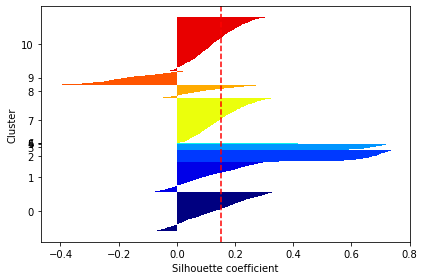

In [116]:
plot_silhouettes(data_s, clusters)

In [117]:
target = target.to_numpy()
target = target.ravel()

In [118]:
c = clusters.ravel()

Everything was encouraging until completeness and homogeneity scores were run. Both scores were around 5% which is far from a reliable measure.

In [119]:
print(completeness_score(target,c))

0.04819007944919147


In [120]:
print(homogeneity_score(target,c))

0.041859537472660434


### Conclusion:

The clustering was probably the least important of the models. The hope was that if a stock was shown to have a high or low priced compared to stocks in the same industry, maybe it was priced similar to other sectors and could be clustered as such. However, the clustering failed to exhibit desirable outcomes.

The original scope of the project was to systematically recommend stocks based on analytics that showed whether a stock was more likely or less likely to outperform the market over a period of time. Given that the dataset was only four quarters, one of which coincided with economic shutdown brought on by Covid-19, the project was shifted to find interesting aspects of return and pricing of stocks. While the classifications within often fail to predict whether a stock will outperform over the next three months, they do give insight into areas that should require increased attention due to perceived mispricing.

There were some promising results with the regression model of predicting returns. In a financial sense, this might be more applicable because a money manager wants to know their alpha (return over market), which can be shown by the results of the regression.  There can be further work done in this area by creating an bagging method that tests a randomized assortment of stocks and averages the predicted returns for each bootstrap's test set.  In the financial world, there is also a concept of neutralizing risk, which isn't taken into account in our model, which only picks stocks that are projected to have a positive return.

Further work can dive deeper into understanding the causes in under and over pricing, and how those mispricings may change over time. If it can be further understood whether the stock prices will revert to a median price, then buy and sell actions could be taken to exploit those changes.